In [29]:
# 1. Kaggle API kurulumu ve veri seti indirme işlemi

# Gerekli kütüphanelerin yüklenmesi
!pip install kaggle ultralytics opencv-python matplotlib torch torchvision pandas numpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 66.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling 

In [ ]:
# Kaggle API için kimlik dosyasının oluşturulması
import os
import json

In [ ]:
# 2. Google Drive'ı bağla
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
# 3. kaggle.json dosyasını yükle
from google.colab import files
files.upload()  # Buradan kaggle.json dosyasını yükle

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"mehmetemre60","key":"5552ef1c5fcf1c9826c0dc207dd37895"}'}

In [ ]:
# 4. Kaggle API anahtarını ilgili dizine taşı
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# İnsan tespiti için uygun veri setini indir
# "People Detection Images Dataset" veri seti
!kaggle datasets download -d constantinwerner/human-detection-dataset

Dataset URL: https://www.kaggle.com/datasets/constantinwerner/human-detection-dataset
License(s): CC0-1.0
 79% 204M/260M [00:00<00:00, 473MB/s] 
100% 260M/260M [00:02<00:00, 101MB/s]


In [ ]:
# İndirilen veri setini çıkartma
!unzip -q human-detection-dataset.zip -d human_detection_data

In [ ]:
# İndirilen veri setinin içeriğini kontrol etme
import glob
path_human = "/content/drive/MyDrive/Human_Detection/human detection dataset/1/*"
path_nonhuman = "/content/drive/MyDrive/Human_Detection/human detection dataset/0/*"

print("İnsan görüntüleri sayısı:", len(glob.glob(path_human)))
print("İnsan olmayan görüntüler sayısı:", len(glob.glob(path_nonhuman)))

İnsan görüntüleri sayısı: 559
İnsan olmayan görüntüler sayısı: 362


In [ ]:
# Örnek görüntüleri gösterme
import matplotlib.pyplot as plt
import cv2
import random

In [17]:
def show_sample_images(directory, n=3, title=""):
    image_paths = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith(('.jpg', '.png', '.jpeg'))]

    if not image_paths:
        print(f"{title}: Klasörde hiç uygun resim yok veya yol hatalı.")
        return

    sample_paths = random.sample(image_paths, min(n, len(image_paths)))

    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(sample_paths):
        img = cv2.imread(img_path)
        if img is None:
            print(f"Hata: {img_path} okunamadı.")
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(f"{title} {i+1}")
    plt.show()

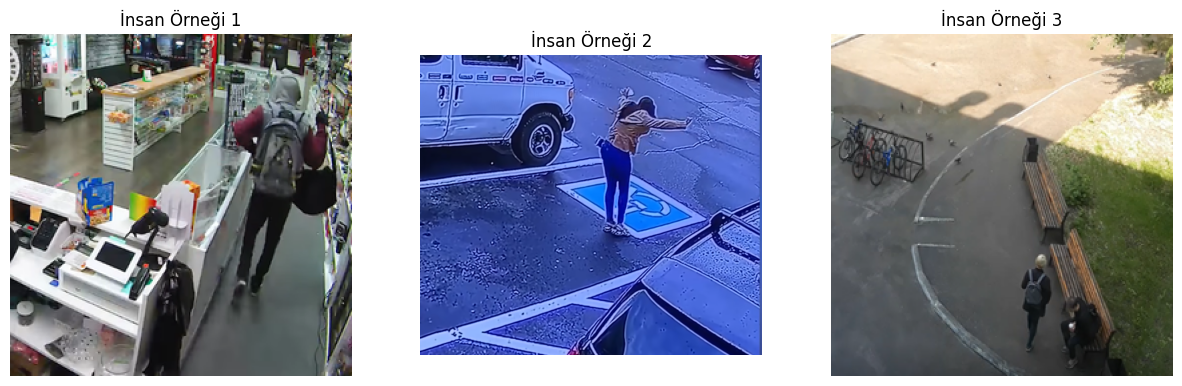

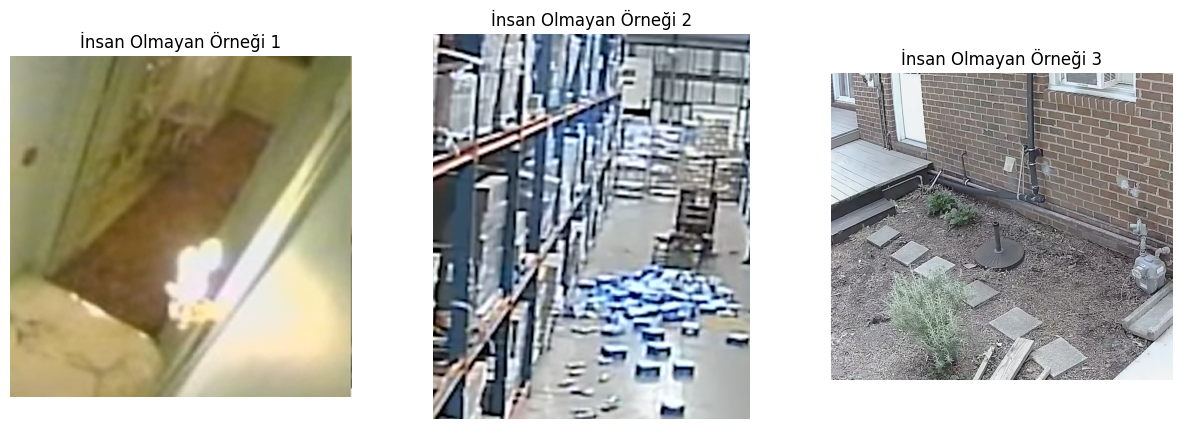

In [18]:
# İnsan ve insan olmayan örnekleri gösterme
show_sample_images("/content/drive/MyDrive/Human_Detection/human detection dataset/1", title="İnsan Örneği")
show_sample_images("/content/drive/MyDrive/Human_Detection/human detection dataset/0", title="İnsan Olmayan Örneği")

In [19]:
# 2. Veri Setini YOLOv8 Formatına Dönüştürme

import os
import cv2
import shutil
import numpy as np
from tqdm import tqdm
from pathlib import Path
import random

In [20]:
def create_yolo_dataset(source_dir, target_dir, train_ratio=0.8, val_ratio=0.1):
    """
    Klasör temelli insan/insan olmayan veri setini YOLOv8 formatına dönüştürür.

    Args:
        source_dir: İçinde '0' ve '1' klasörleri olan klasör yolu
        target_dir: YOLO veri setinin oluşacağı klasör
    """
    # Klasörleri oluştur
    os.makedirs(target_dir, exist_ok=True)
    images_dir = os.path.join(target_dir, "images")
    labels_dir = os.path.join(target_dir, "labels")

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(images_dir, split), exist_ok=True)
        os.makedirs(os.path.join(labels_dir, split), exist_ok=True)

    # Tüm veriyi topla
    all_images = []
    for class_id in ["0", "1"]:
        class_folder = os.path.join(source_dir, class_id)
        if not os.path.exists(class_folder):
            print(f"UYARI: {class_folder} klasörü bulunamadı, atlanıyor.")
            continue
        for file in os.listdir(class_folder):
            if file.endswith((".jpg", ".png", ".jpeg")):
                rel_path = os.path.join(class_id, file)
                all_images.append((rel_path, int(class_id)))

    # Veriyi karıştır ve böl
    random.shuffle(all_images)
    total = len(all_images)
    train_end = int(train_ratio * total)
    val_end = int((train_ratio + val_ratio) * total)

    dataset_splits = {
        "train": all_images[:train_end],
        "val": all_images[train_end:val_end],
        "test": all_images[val_end:]
    }

    # Görselleri kopyala ve sahte bbox etiketlerini yaz
    for split, data in dataset_splits.items():
        print(f"\n{split} seti işleniyor ({len(data)} görüntü)...")
        for rel_path, class_id in tqdm(data):
            src_img_path = os.path.join(source_dir, rel_path)
            filename = os.path.basename(src_img_path)

            img = cv2.imread(src_img_path)
            if img is None:
                print(f"HATA: {src_img_path} yüklenemedi, atlandı.")
                continue

            dst_img_path = os.path.join(images_dir, split, filename)
            shutil.copy(src_img_path, dst_img_path)

            label_path = os.path.join(labels_dir, split, os.path.splitext(filename)[0] + ".txt")

            # Sahte bbox (orta konumda, genişlik/yükseklik %60-90)
            bbox_width = random.uniform(0.6, 0.9)
            bbox_height = random.uniform(0.6, 0.9)
            x_center = 0.5
            y_center = 0.5

            with open(label_path, 'w') as f:
                f.write(f"{class_id} {x_center} {y_center} {bbox_width} {bbox_height}")

In [21]:
source_dir = "/content/drive/MyDrive/Human_Detection/human detection dataset"
target_dir = "/content/drive/MyDrive/Human_Detection/yolo_dataset"

create_yolo_dataset(source_dir, target_dir)



train seti işleniyor (736 görüntü)...


100%|██████████| 736/736 [04:15<00:00,  2.88it/s]



val seti işleniyor (92 görüntü)...


100%|██████████| 92/92 [00:18<00:00,  4.90it/s]



test seti işleniyor (93 görüntü)...


100%|██████████| 93/93 [00:18<00:00,  4.93it/s]


In [22]:
yaml_path = os.path.join(target_dir, "data.yaml")

with open(yaml_path, "w") as f:
    f.write(
        f"path: {target_dir}\n"
        f"train: images/train\n"
        f"val: images/val\n"
        f"test: images/test\n"
        f"nc: 2\n"
        f"names: ['non-human', 'human']\n"
    )


In [23]:
# Veri setini YOLO formatına dönüştür
create_yolo_dataset(
    source_dir="/content/drive/MyDrive/Human_Detection/human detection dataset",
    target_dir="yolo_human_dataset",
    train_ratio=0.8,
    val_ratio=0.1
)


train seti işleniyor (736 görüntü)...


100%|██████████| 736/736 [00:19<00:00, 37.85it/s]



val seti işleniyor (92 görüntü)...


100%|██████████| 92/92 [00:02<00:00, 38.96it/s]



test seti işleniyor (93 görüntü)...


100%|██████████| 93/93 [00:01<00:00, 50.48it/s]


In [24]:
# Veri seti yapısını kontrol et
!find yolo_human_dataset -type f | wc -l
!cat yolo_human_dataset/dataset.yaml
!ls -la yolo_human_dataset/images/train | head -5
!cat $(find yolo_human_dataset/labels/train -type f | head -1)

1378
cat: yolo_human_dataset/dataset.yaml: No such file or directory
total 152896
drwxr-xr-x 2 root root   16384 Jun  1 23:33 .
drwxr-xr-x 5 root root    4096 Jun  1 23:26 ..
-rw------- 1 root root  327271 Jun  1 23:32 0.png
-rw------- 1 root root   75760 Jun  1 23:32 101.png
1 0.5 0.5 0.8790059653496062 0.7991670528475486

In [25]:
# Örnek bir etiket ve görüntüyü görselleştir
def visualize_yolo_sample():
    # Rastgele bir eğitim görüntüsü seç
    train_imgs = os.listdir("yolo_human_dataset/images/train")
    sample_img = random.choice(train_imgs)
    img_path = os.path.join("yolo_human_dataset/images/train", sample_img)
    label_path = os.path.join("yolo_human_dataset/labels/train",
                            os.path.splitext(sample_img)[0] + ".txt")

    # Görüntüyü yükle
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]

    # Etiketi oku
    with open(label_path, 'r') as f:
        line = f.readline().strip().split()
        class_id, x_center, y_center, width, height = map(float, line)

    # Normalize edilmiş koordinatları piksel koordinatlarına çevir
    x_center = int(x_center * w)
    y_center = int(y_center * h)
    width = int(width * w)
    height = int(height * h)

    # Bounding box koordinatları
    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    # Bounding box çiz
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(img, "person", (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # Görüntüyü göster
    plt.figure(figsize=(10, 8))
    plt.imshow(img)
    plt.title(f"YOLO Formatında Örnek: {sample_img}")
    plt.axis('off')
    plt.show()

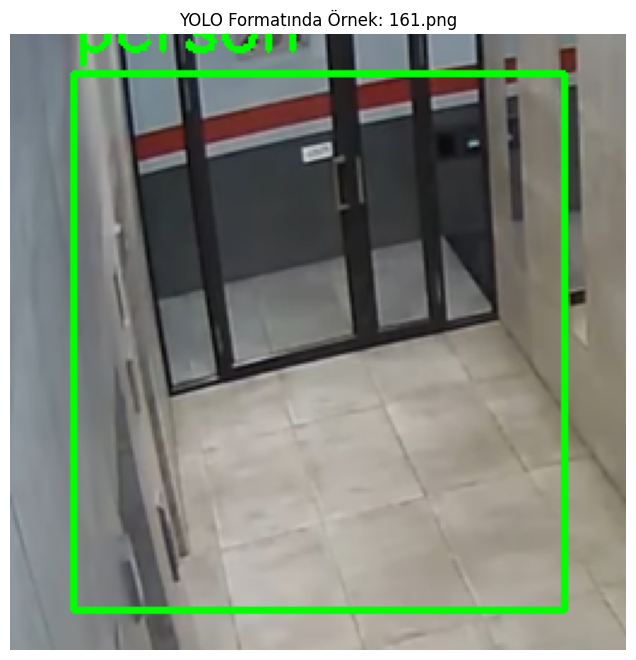

In [26]:
# Örnek görseli görüntüle
visualize_yolo_sample()

In [30]:
# 3. YOLOv8 Modelini Sıfırdan İnsan Tespiti İçin Eğitme

from ultralytics import YOLO
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [31]:
# GPU kullanılabilirliğini kontrol et
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(f"Eğitim için kullanılacak cihaz: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Versiyonu: {torch.version.cuda}")

Eğitim için kullanılacak cihaz: cpu


In [32]:
# Özelleştirilmiş model eğitimi için YOLOv8 yapılandırması
def train_custom_human_detection_model():
    # YOLOv8 nano modelini yükle (küçük ve hızlı model)
    model = YOLO("yolov8n.pt")

    print("YOLOv8n modeli yüklendi.")
    print(f"Orijinal model sınıfları: {model.names}")

    # Eğitim parametreleri
    results = model.train(
        data=yaml_path,                           # Veri seti YAML dosyası
        epochs=5,                                 # Epoch sayısı
        patience=20,                              # Early stopping (20 epoch boyunca iyileşme olmazsa durdur)
        batch=16,                                 # Batch size
        imgsz=640,                                # Görüntü boyutu
        device=device,                            # Eğitim cihazı
        workers=4,                                # Veri yükleme işçi sayısı
        project="human_detection_project",        # Proje adı
        name="yolov8n_human_only",                # Çalışma adı
        exist_ok=True,                            # Var olan klasörün üzerine yaz
        single_cls=True,                          # Tek sınıf modu (sadece insan)
        verbose=True,                             # Ayrıntılı çıktı
        amp=True,                                 # Otomatik karışık hassasiyet
        close_mosaic=10,                          # Son 10 epoch'ta mozaik veri artırmayı kapat
        cos_lr=True,                              # Kosinüs LR planlaması
        lr0=0.01,                                 # Başlangıç öğrenme oranı
        lrf=0.001,                                # Final öğrenme oranı
        weight_decay=0.0005,                      # Ağırlık çürümesi
        warmup_epochs=3.0,                        # Isınma aşaması epoch sayısı
        warmup_momentum=0.8,                      # Isınma momentumu
        warmup_bias_lr=0.1,                       # Isınma bias öğrenme oranı
        box=7.5,                                  # Bounding box kaybı ağırlığı
        cls=0.5,                                  # Sınıf kaybı ağırlığı
        dfl=1.5,                                  # DFL kaybı ağırlığı
        nbs=64,                                   # Nominal batch boyutu
        val=True,                                 # Doğrulama yapılacak
    )

    # Eğitim sonuçlarını döndür
    return results, model

In [33]:
# Modeli eğit
print("İnsan tespiti modeli eğitimi başlatılıyor...")
results, trained_model = train_custom_human_detection_model()


İnsan tespiti modeli eğitimi başlatılıyor...


100%|██████████| 6.25M/6.25M [00:00<00:00, 115MB/s]


YOLOv8n modeli yüklendi.
Orijinal model sınıfları: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: 'couch', 58: 'potted plant', 59: 'bed', 60: 'dining table', 61: 'toilet', 62: 'tv', 63: 'laptop', 64: 'mouse', 65: 'rem

100%|██████████| 755k/755k [00:00<00:00, 92.1MB/s]

Overriding class names with single class.
Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7    

 15                  -1  1     37248  ultralytics.nn.modules.block.C2f             [192, 64, 1]                  
 16                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
 17            [-1, 12]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 18                  -1  1    123648  ultralytics.nn.modules.block.C2f             [192, 128, 1]                 
 19                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 20             [-1, 9]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 21                  -1  1    493056  ultralytics.nn.modules.block.C2f             [384, 256, 1]                 
 22        [15, 18, 21]  1    751507  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
Model summary: 129 layers, 3,011,043 parameters, 3,011,027 gradients, 8.2 GFLOPs

Transf

train: Scanning /content/drive/MyDrive/Human_Detection/yolo_dataset/labels/train... 559 images, 0 backgrounds, 0 corrupt: 100%|██████████| 559/559 [00:33<00:00, 16.48it/s]

train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/0.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/137.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/139.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/143.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/144.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/146.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/154.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/156.png: corrupt JPEG restored and saved
train: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/train/163.png: corrupt JPEG rest

train: New cache created: /content/drive/MyDrive/Human_Detection/yolo_dataset/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.8±0.5 ms, read: 9.4±11.7 MB/s, size: 180.4 KB)


val: Scanning /content/drive/MyDrive/Human_Detection/yolo_dataset/labels/val... 227 images, 0 backgrounds, 0 corrupt: 100%|██████████| 227/227 [00:28<00:00,  7.88it/s]

val: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/val/136.png: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/val/171.png: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/val/494.png: corrupt JPEG restored and saved


val: New cache created: /content/drive/MyDrive/Human_Detection/yolo_dataset/labels/val.cache
Plotting labels to human_detection_project/yolov8n_human_only/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to human_detection_project/yolov8n_human_only
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/5         0G      1.698      2.243       2.17         31        640: 100%|██████████| 35/35 [08:21<00:00, 14.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:16<00:00,  9.52s/it]

                   all        227        227      0.228       0.63      0.506      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/5         0G      1.453      1.531      1.854         43        640: 100%|██████████| 35/35 [08:06<00:00, 13.89s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:14<00:00,  9.27s/it]

                   all        227        227      0.608      0.696      0.624      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/5         0G      1.454      1.361      1.848         38        640: 100%|██████████| 35/35 [08:00<00:00, 13.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:13<00:00,  9.18s/it]

                   all        227        227      0.682      0.573      0.651      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        4/5         0G      1.358      1.223      1.753         44        640: 100%|██████████| 35/35 [07:57<00:00, 13.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:12<00:00,  9.05s/it]

                   all        227        227      0.964      0.956      0.985      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        5/5         0G      1.319      1.167      1.753         44        640: 100%|██████████| 35/35 [07:56<00:00, 13.60s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:10<00:00,  8.80s/it]

                   all        227        227      0.986      0.987      0.994      0.612



5 epochs completed in 0.775 hours.
Optimizer stripped from human_detection_project/yolov8n_human_only/weights/last.pt, 6.2MB
Optimizer stripped from human_detection_project/yolov8n_human_only/weights/best.pt, 6.2MB

Validating human_detection_project/yolov8n_human_only/weights/best.pt...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 8/8 [01:06<00:00,  8.36s/it]


                   all        227        227      0.986      0.987      0.994      0.612
Speed: 4.4ms preprocess, 263.5ms inference, 0.0ms loss, 1.7ms postprocess per image
Results saved to human_detection_project/yolov8n_human_only


In [34]:
print(results.results_dict.keys())

dict_keys(['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'fitness'])


In [35]:
for k, v in results.results_dict.items():
    print(f"{k} → {v}")

metrics/precision(B) → 0.9857510939479127
metrics/recall(B) → 0.986784140969163
metrics/mAP50(B) → 0.9938045831438933
metrics/mAP50-95(B) → 0.6121169718780652
fitness → 0.6502857330046481


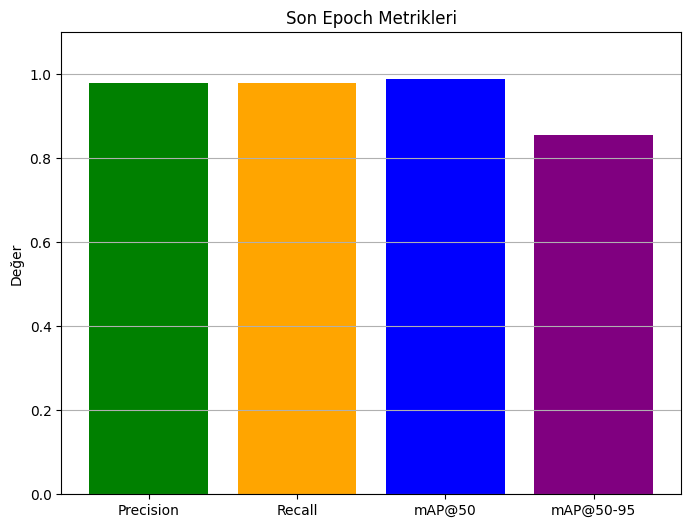

In [36]:
metrics = {
    'Precision': 0.979751,
    'Recall': 0.97878,
    'mAP@50': 0.98880,
    'mAP@50-95': 0.855116
}

plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values(), color=['green', 'orange', 'blue', 'purple'])
plt.title("Son Epoch Metrikleri")
plt.ylim(0, 1.1)
plt.ylabel("Değer")
plt.grid(True, axis='y')
plt.show()

In [37]:
# Eğitilen modeli değerlendir
val_results = trained_model.val()
print(f"\nEğitilen modelin değerlendirme sonuçları:")
print(f"mAP@50: {val_results.box.map50:.4f}")
print(f"mAP@50-95: {val_results.box.map:.4f}")
print(f"Precision: {val_results.box.mp:.4f}")
print(f"Recall: {val_results.box.mr:.4f}")


Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.7±0.2 ms, read: 38.9±33.6 MB/s, size: 190.5 KB)


val: Scanning /content/drive/MyDrive/Human_Detection/yolo_dataset/labels/val.cache... 227 images, 0 backgrounds, 0 corrupt: 100%|██████████| 227/227 [00:00<?, ?it/s]

val: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/val/136.png: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/val/171.png: corrupt JPEG restored and saved
val: /content/drive/MyDrive/Human_Detection/yolo_dataset/images/val/494.png: corrupt JPEG restored and saved



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 15/15 [01:00<00:00,  4.04s/it]


                   all        227        227      0.985      0.987      0.994      0.612
Speed: 1.7ms preprocess, 237.2ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to human_detection_project/yolov8n_human_only

Eğitilen modelin değerlendirme sonuçları:
mAP@50: 0.9938
mAP@50-95: 0.6121
Precision: 0.9851
Recall: 0.9868


In [38]:
# Eğitilen modeli kaydet ve optimize et
# ONNX formatı dronelarda çalıştırmak için idealdir
print("\nModeli ONNX formatında dışa aktarma...")
trained_model.export(format="onnx", simplify=True)


Modeli ONNX formatında dışa aktarma...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel CPUs. Learn more at https://docs.ultralytics.com/integrations/openvino/

PyTorch: starting from 'human_detection_project/yolov8n_human_only/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0,<1.18.0', 'onnxslim>=0.1.53', 'onnxruntime'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 3.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


ONNX: starting export with onnx 1.17.0 opset 19...
ONNX: slimming with onnxslim 0.1.55...
ONNX: export success ✅ 5.2s, saved as 'human_detection_project/yolov8n_human_only/weights/best.onnx' (11.7 MB)

Export complete (5.9s)
Results saved to /content/human_detection_project/yolov8n_human_only/weights
Predict:   

'human_detection_project/yolov8n_human_only/weights/best.onnx'

In [39]:
# TorchScript formatında dışa aktarma (PyTorch ekosistemi için)
print("Modeli TorchScript formatında dışa aktarma...")
trained_model.export(format="torchscript")

Modeli TorchScript formatında dışa aktarma...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'human_detection_project/yolov8n_human_only/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)

TorchScript: starting export with torch 2.5.1+cu124...
TorchScript: export success ✅ 2.6s, saved as 'human_detection_project/yolov8n_human_only/weights/best.torchscript' (11.9 MB)

Export complete (3.1s)
Results saved to /content/human_detection_project/yolov8n_human_only/weights
Predict:         yolo predict task=detect model=human_detection_project/yolov8n_human_only/weights/best.torchscript imgsz=640  
Validate:        yolo val task=detect model=human_detection_project/yolov8n_human_only/weights/best.torchscript imgsz=640 data=/content/drive/MyDrive/Human_Detection/yolo_dataset/data.yaml  
Visualize:       https://netron.app


'human_detection_project/yolov8n_human_only/weights/best.torchscript'

In [40]:
# OpenVINO formatında dışa aktarma (intel cihazlar için)
print("Modeli OpenVINO formatında dışa aktarma...")
trained_model.export(format="openvino")

Modeli OpenVINO formatında dışa aktarma...
Ultralytics 8.3.146 🚀 Python-3.11.11 torch-2.5.1+cu124 CPU (Intel Xeon 2.20GHz)

PyTorch: starting from 'human_detection_project/yolov8n_human_only/weights/best.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.9 MB)
requirements: Ultralytics requirement ['openvino>=2024.0.0'] not found, attempting AutoUpdate...

requirements: AutoUpdate success ✅ 1.1s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect


OpenVINO: starting export with openvino 2025.1.0-18503-6fec06580ab-releases/2025/1...
OpenVINO: export success ✅ 7.8s, saved as 'human_detection_project/yolov8n_human_only/weights/best_openvino_model/' (11.8 MB)

Export complete (8.3s)
Results saved to /content/human_detection_project/yolov8n_human_only/weights
Predict:         yolo predict task=detect model=human_detection_project/yolov8n_human_only/weights/best_openvino_model imgsz=640  
Validate:        yolo val task=detect mode

'human_detection_project/yolov8n_human_only/weights/best_openvino_model'

In [41]:
# Aktarılan model dosyalarını listele
import glob
print("\nOluşturulan model dosyaları:")
for model_file in glob.glob("human_detection_project/yolov8n_human_only/weights/*"):
    file_size = os.path.getsize(model_file) / (1024 * 1024)  # MB cinsinden
    print(f"{os.path.basename(model_file)}: {file_size:.2f} MB")


Oluşturulan model dosyaları:
best.torchscript: 11.89 MB
best.onnx: 11.68 MB
best.pt: 5.95 MB
best_openvino_model: 0.00 MB
last.pt: 5.95 MB


In [90]:
# Test veri seti üzerinde örnekleri görselleştir
print("\nTest veri seti üzerinde örnekleri görselleştirme...")
test_images = sorted(glob.glob("yolo_human_dataset/images/test/*"))[0:20]  # İlk 5 test görüntüsü


Test veri seti üzerinde örnekleri görselleştirme...


In [91]:
def visualize_predictions(model, image_paths):
    import matplotlib.pyplot as plt
    import cv2

    plt.figure(figsize=(15, 12))
    shown = 0  # Gösterilen görüntü sayısı

    for i, img_path in enumerate(image_paths):
        if shown >= 20:
            break

        results = model.predict(img_path, conf=0.30)
        boxes = results[0].boxes

        best_human_box = None
        max_confidence = 0

        if boxes is not None and len(boxes) > 0:
            for box in boxes:
                cls = int(box.cls)
                conf = float(box.conf)
                if cls == 0:  # İnsan sınıfı
                    if conf > max_confidence:
                        max_confidence = conf
                        best_human_box = box

        if best_human_box:
            res_plotted = results[0].plot()
            res_plotted = cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB)
            plt.subplot(4, 5, shown + 1)
            plt.imshow(res_plotted)

            if max_confidence >= 0.80:
                plt.title("İnsan Tespit Edildi")
            else:
                plt.title("İnsan Tespit Edilemedi")

            plt.axis('off')
            shown += 1
        else:
            print(f"[{i+1}] İnsan tespiti bulunamadı: {img_path}")

    if shown == 0:
        print("Hiçbir görüntüde insan bulunamadı.")
    plt.tight_layout()
    plt.show()


In [92]:
# Test görüntüleri üzerinde tahminleri görselleştir
visualize_predictions(trained_model, test_images)

Output hidden; open in https://colab.research.google.com to view.